<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Descriptive-statistics" data-toc-modified-id="Descriptive-statistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Descriptive statistics</a></span></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualizations</a></span></li><li><span><a href="#Linear-and-nonlinear-models" data-toc-modified-id="Linear-and-nonlinear-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Linear and nonlinear models</a></span></li><li><span><a href="#Neural-network-model-with-TensorFlow" data-toc-modified-id="Neural-network-model-with-TensorFlow-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Neural network model with TensorFlow</a></span></li></ul></div>

<h1>Student Alcohol Consumption Regression</h1>

<img style="float: left; margin-right: 15px; width: 40%; height: 40%; " src="images/beer.jpg" />

# Purpose

The purpose of this write-up is to develop and compare a number of predictive regression models for the classic Student Alcohol Consumption dataset.  

Goals include:
* Examine and explore the data
* Develop linear and nonlinear predictive classification models with Scikit-Learn
* Develop a predictive neural network classifier with TensorFlow

Dataset source:  [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)

# Load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load libraries
import os
import math
import numpy as np
from matplotlib import pyplot
import seaborn as sns

import pandas as pd
from pandas import read_csv
from pandas import set_option
from pandas import DataFrame
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
def corrTableColors(value):
    color = 'black'

    if value == 1:
        color = 'white'
    elif value < -0.7:
        color = 'red'
    elif value > 0.7:
        color = 'green'

    return 'color: %s' % color

# Import the data

In [4]:
# Import the CSV files
math = read_csv('./datasets/student-mat.csv', sep = ';')
por = read_csv('./datasets/student-por.csv', sep = ';')

# Next we want to add a column for the course
# This will help us track which row came from which CSV file in the next step
math['course'] = 'math'
por['course'] = 'por'

# Merge the two data files
merged = math.append(por)

# Examine the shapes
print("Math shape: ", math.shape)
print("Por shape: ", por.shape)
print("Merged shape: ", merged.shape)


Math shape:  (395, 34)
Por shape:  (649, 34)
Merged shape:  (1044, 34)


# Initial data prep

In [5]:
# From the notes on the dataset there are students who are found in both data files
# Attempt to resolve this

# Which combination of columns will uniquely a record
groupByColumns = ["school", "sex", "age", "address", "famsize", "Pstatus", "Medu",
                  "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"]

# How many rows should we have once dupes are accounted for?
print("Target number of rows: ", len(merged.groupby(groupByColumns).size()))

Target number of rows:  662


In [6]:
# Get index of dupes
dupeMask = merged.duplicated(keep = False, subset = groupByColumns)

# Split the dataset into dupe and non dupes
dupes = merged[dupeMask]
nonDupes = merged[~dupeMask]

# Quick summary
print("Number of dupes: ", len(dupes))
print("Number of ~dupes: ", len(nonDupes))

Number of dupes:  751
Number of ~dupes:  293


In [7]:
# Now we want to compress the dupes down into a single record
bothClassesMask = dupes.duplicated(subset = groupByColumns, keep = 'first')
print(bothClassesMask.value_counts(), "\n")

# Exclude the dupes
bothClasses = dupes[~bothClassesMask]
print("Both classes no dupe count: ", len(bothClasses), "\n")

# Label the non-dupes as being in both classes
bothClasses['course'] = 'both'

# Now add the students in both classes to the orig. list of non-dupes
students = nonDupes.append(bothClasses)

print("Final dataset count: ", len(students), "\n")

True     382
False    369
dtype: int64 

Both classes no dupe count:  369 

Final dataset count:  662 



# Feature engineering

In [8]:
# Add a feature to quantify how much alcohol the student drinks per week
students['alcohol'] = ((students.Walc * 2) + (students.Dalc * 5)) / 7

# Resolve any rounding
students['alcohol'] = students['alcohol'].map(lambda x: np.ceil(x))

# Assign a binary classification for 'drinker' or 'non-drinker'
students['drinker'] = students['alcohol'].map(lambda x: 1 if x < 2 else 0)

# Finally, examine the results
students.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,course,alcohol,drinker
128,GP,M,18,R,GT3,T,2,2,services,other,...,1,2,4,0,7,4,0,math,2.0,0
161,GP,M,15,R,GT3,T,3,2,other,other,...,1,4,3,6,5,9,7,math,2.0,0
162,GP,M,16,U,LE3,T,1,2,other,other,...,2,4,5,0,7,0,0,math,3.0,0
163,GP,M,17,U,GT3,T,1,3,at_home,services,...,1,4,2,2,10,10,10,math,2.0,0
165,GP,M,16,U,GT3,T,3,2,services,services,...,1,1,2,16,12,11,12,math,1.0,1


# Explore the data

## Descriptive statistics

In [9]:
students.shape

(662, 36)

In [10]:
students.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,course,alcohol,drinker
128,GP,M,18,R,GT3,T,2,2,services,other,...,1,2,4,0,7,4,0,math,2.0,0
161,GP,M,15,R,GT3,T,3,2,other,other,...,1,4,3,6,5,9,7,math,2.0,0
162,GP,M,16,U,LE3,T,1,2,other,other,...,2,4,5,0,7,0,0,math,3.0,0
163,GP,M,17,U,GT3,T,1,3,at_home,services,...,1,4,2,2,10,10,10,math,2.0,0
165,GP,M,16,U,GT3,T,3,2,services,services,...,1,1,2,16,12,11,12,math,1.0,1


In [11]:
students.dtypes

school         object
sex            object
age             int64
address        object
famsize        object
Pstatus        object
Medu            int64
Fedu            int64
Mjob           object
Fjob           object
reason         object
guardian       object
traveltime      int64
studytime       int64
failures        int64
schoolsup      object
famsup         object
paid           object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel          int64
freetime        int64
goout           int64
Dalc            int64
Walc            int64
health          int64
absences        int64
G1              int64
G2              int64
G3              int64
course         object
alcohol       float64
drinker         int64
dtype: object

In [12]:
set_option('display.width', 200)
set_option('precision', 2)
students.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,alcohol,drinker
count,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00,662.00
mean,16.81,2.49,2.29,1.56,1.93,0.33,3.94,3.18,3.17,1.50,2.28,3.53,4.93,10.73,10.71,10.73,2.02,0.38
std,1.27,1.13,1.09,0.74,0.83,0.72,0.94,1.06,1.16,0.93,1.29,1.43,6.86,3.08,3.53,4.11,1.06,0.49
min,15.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,3.00,0.00,0.00,1.00,0.00
25%,16.00,2.00,1.00,1.00,1.00,0.00,4.00,3.00,2.00,1.00,1.00,2.00,0.00,8.00,9.00,9.00,1.00,0.00
50%,17.00,2.00,2.00,1.00,2.00,0.00,4.00,3.00,3.00,1.00,2.00,4.00,3.00,10.00,11.00,11.00,2.00,0.00
75%,18.00,4.00,3.00,2.00,2.00,0.00,5.00,4.00,4.00,2.00,3.00,5.00,8.00,13.00,13.00,13.00,3.00,1.00
max,22.00,4.00,4.00,4.00,4.00,3.00,5.00,5.00,5.00,5.00,5.00,5.00,75.00,19.00,19.00,20.00,5.00,1.00


In [13]:
students.groupby(['school']).size()

school
GP    434
MS    228
dtype: int64

In [14]:
students.groupby(['course']).size()

course
both    369
math     25
por     268
dtype: int64

In [15]:
students.groupby(['drinker', 'sex']).size()

drinker  sex
0        F      212
         M      200
1        F      178
         M       72
dtype: int64

In [16]:
corr = students.corr(method = "pearson")
corr.style.applymap(corrTableColors)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,alcohol,drinker
age,1,-0.12,-0.13,0.015,0.0015,0.28,-0.0085,-0.0024,0.095,0.13,0.069,-0.013,0.17,-0.11,-0.13,-0.13,0.11,-0.079
Medu,-0.12,1,0.64,-0.24,0.1,-0.16,0.01,-0.011,0.023,-0.018,-0.036,-0.0022,0.096,0.21,0.2,0.18,-0.026,0.033
Fedu,-0.13,0.64,1,-0.19,0.045,-0.17,0.016,0.0094,0.053,-0.0088,0.032,0.038,0.068,0.19,0.16,0.14,0.0063,0.0021
traveltime,0.015,-0.24,-0.19,1,-0.066,0.079,-0.01,-0.0075,0.04,0.084,0.061,-0.045,-0.05,-0.072,-0.11,-0.073,0.071,-0.0094
studytime,0.0015,0.1,0.045,-0.066,1,-0.13,0.0039,-0.078,-0.078,-0.14,-0.22,-0.054,-0.039,0.17,0.13,0.098,-0.19,0.18
failures,0.28,-0.16,-0.17,0.079,-0.13,1,-0.068,0.11,0.06,0.089,0.085,0.035,0.088,-0.37,-0.36,-0.36,0.073,-0.018
famrel,-0.0085,0.01,0.016,-0.01,0.0039,-0.068,1,0.14,0.091,-0.07,-0.093,0.11,-0.068,0.061,0.053,0.061,-0.086,0.098
freetime,-0.0024,-0.011,0.0094,-0.0075,-0.078,0.11,0.14,1,0.33,0.12,0.13,0.089,-0.042,-0.04,-0.061,-0.059,0.13,-0.056
goout,0.095,0.023,0.053,0.04,-0.078,0.06,0.091,0.33,1,0.25,0.4,0.0022,0.025,-0.094,-0.091,-0.082,0.34,-0.28
Dalc,0.13,-0.018,-0.0088,0.084,-0.14,0.089,-0.07,0.12,0.25,1,0.62,0.065,0.13,-0.11,-0.085,-0.075,0.87,-0.42


Not really a lot of correlations other than the ones you'd expect.  Example:  It makes sense that students with a high/low G1 grade score would also have a high/low G2 and/or G3 grade score.

In [17]:
students.skew()

age           4.22e-01
Medu         -6.39e-03
Fedu          2.34e-01
traveltime    1.25e+00
studytime     6.98e-01
failures      2.36e+00
famrel       -1.11e+00
freetime     -1.90e-01
goout        -2.31e-03
Dalc          2.12e+00
Walc          6.25e-01
health       -4.92e-01
absences      3.84e+00
G1            3.04e-01
G2           -4.16e-01
G3           -8.05e-01
alcohol       1.02e+00
drinker       5.06e-01
dtype: float64

## Visualizations

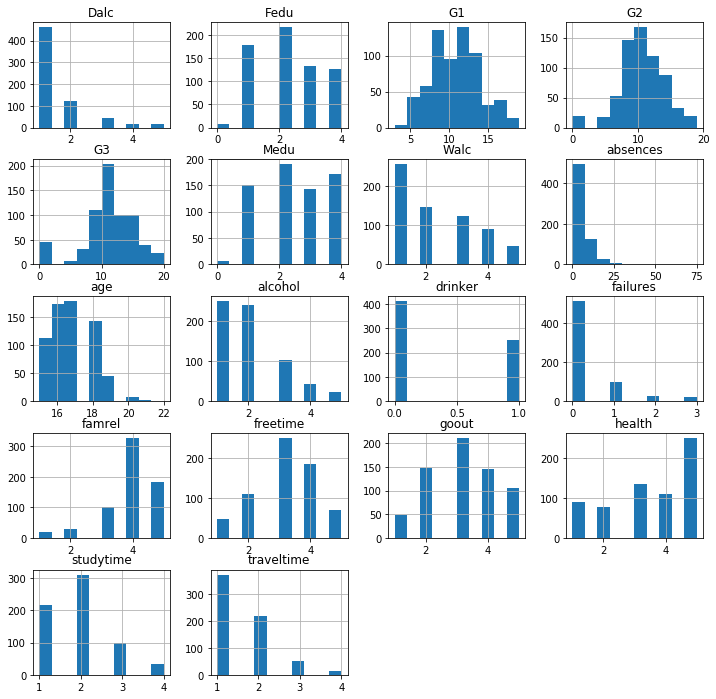

In [18]:
students.hist(figsize = (12,12))
pyplot.show()

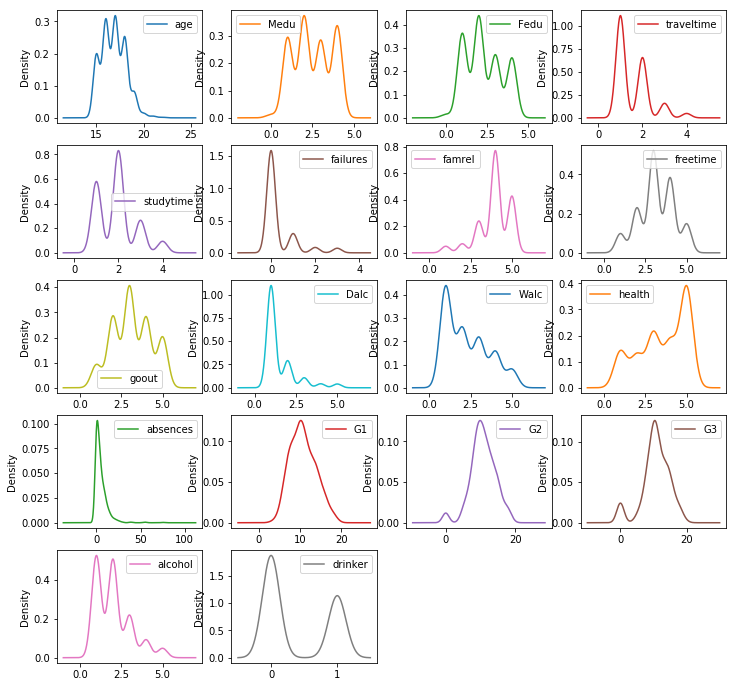

In [19]:
students.plot(kind = 'density', subplots = True, layout = (5,4), sharex = False, figsize = (12, 12))
pyplot.show()

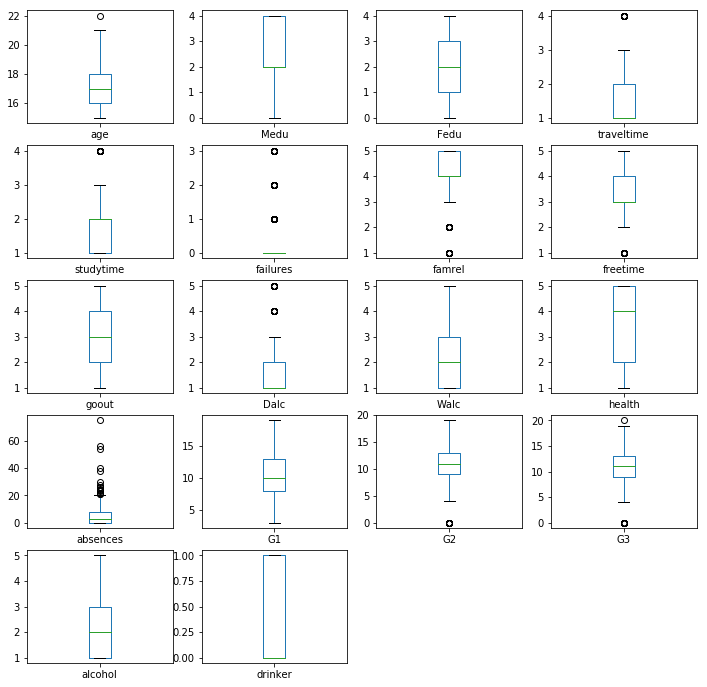

In [20]:
students.plot(kind="box", subplots = True, layout = (5,4), sharex = False, sharey = False, figsize = (12, 12))
pyplot.show()

In [21]:
# Skipping scatter_matrix; not very helpful.

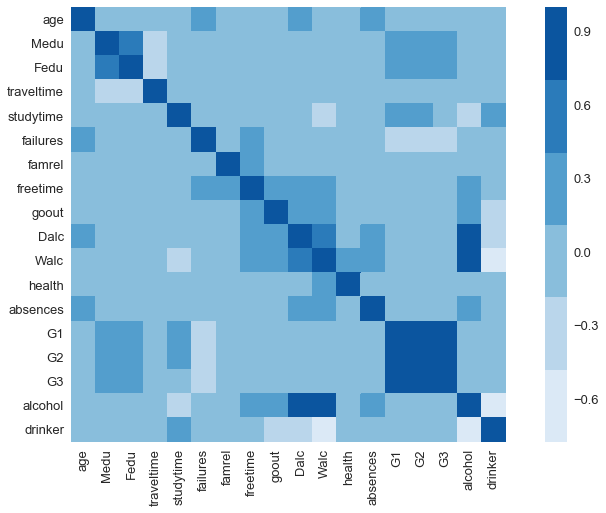

In [22]:
sns.set(font_scale = 1.3) 
fig, ax = pyplot.subplots(figsize=(14, 8)) 
sns.heatmap(students.corr(), vmax = 1.0, square = True, ax = ax, cmap = sns.color_palette("Blues"));

# Encode the data

In [23]:
# Remove Dalc and Walc since we're using them in the feature we engineered, alcohol
students = students.drop(['Walc', 'Dalc'], axis = 1)
print(list(students))

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3', 'course', 'alcohol', 'drinker']


In [24]:
# Split the observations into observations and labels
data = students.loc[:, students.columns != 'drinker']
labels = students.loc[:, students.columns == 'drinker']

print(list(data))
print(data.shape)
print(" ")
print(list(labels))
print(labels.shape)

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3', 'course', 'alcohol']
(662, 33)
 
['drinker']
(662, 1)


In [25]:
# One hot encode the observational categorical variables
data = pd.get_dummies(data, columns = list(data.select_dtypes(include = ['object'])))

In [26]:
data.head(5)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,...,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,course_both,course_math,course_por
128,18,2,2,1,1,2,3,3,3,4,...,1,0,1,0,1,1,0,0,1,0
161,15,3,2,2,2,2,4,4,4,3,...,1,0,1,0,1,0,1,0,1,0
162,16,1,2,2,1,1,4,4,4,5,...,1,0,1,1,0,1,0,0,1,0
163,17,1,3,1,1,0,5,3,3,2,...,1,1,0,0,1,1,0,0,1,0
165,16,3,2,2,1,1,4,5,2,2,...,0,1,0,1,0,1,0,0,1,0


Encoding the data has added a number of columns to the data set....

We could also standardize the dataset here as well, but fankly it's such a simple dataset there is likely no need.

In [27]:
# Split out validation set -- 80/20 split
seed = 10
valSize = 0.2

xTrain, xVal, yTrain, yVal = train_test_split(data, labels, test_size = valSize, random_state = seed)

print("--------")
print("xTrain.shape = ", xTrain.shape)
print("yTrain.shape = ", yTrain.shape)
print("xVal.shape = ", xVal.shape)
print("yVal.shape = ", yVal.shape)

--------
xTrain.shape =  (529, 61)
yTrain.shape =  (529, 1)
xVal.shape =  (133, 61)
yVal.shape =  (133, 1)


# Predictive Models

## Linear and nonlinear models

In [28]:
# Create some baselines using non-NN models

# Init vars
models = []
results = {}
folds = 10
seed = 10
score = 'accuracy'

# Instantiate model objects
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Create a Pandas DF to hold all our spiffy results
df = DataFrame(columns = ['Model', 'Mean', 'StdDev'])

# Run the models
for modelName, model in models:
    # Implement K-fold cross validation where K = 10
    kFold = KFold(n_splits = folds, random_state = seed)
    results[modelName] = cross_val_score(model, xTrain, yTrain, cv = kFold, scoring = score)
    df.loc[len(df)] = list([modelName, results[modelName].mean(), results[modelName].std()])

# Print results sorted by Mean desc, StdDev asc, Model asc
print(df.sort_values(by = ['Mean', 'StdDev', 'Model'], ascending = [False, True, True]))

  Model  Mean    StdDev
3  CART  1.00  0.00e+00
0    LR  1.00  0.00e+00
4    NB  1.00  7.55e-03
1   LDA  0.94  4.54e-02
5   SVM  0.89  3.59e-02
2   KNN  0.70  8.69e-02


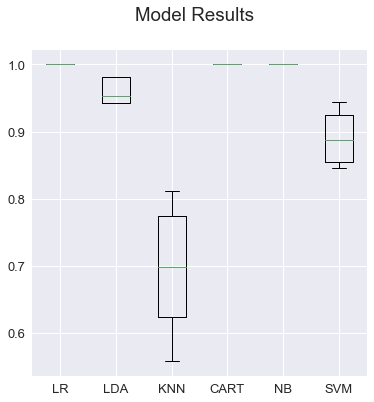

In [29]:
figure = pyplot.figure(figsize = (6,6))
figure.suptitle("Model Results")
axis = figure.add_subplot(111)
pyplot.boxplot(results.values())
axis.set_xticklabels(results.keys())
pyplot.show()

In [30]:
# Let's examine predictions from the top three models
for i, m in enumerate(models):
    pModelName = m[0]
    pModel = m[1]
    
    pModel.fit(xTrain, yTrain)
    preds = pModel.predict(xVal)
        
    print("*************")
    print("*", pModelName)
    print("*************\n")
    print("accuracy_score = ", accuracy_score(yVal, preds), "\n")
    print("confusion_matrix\n", confusion_matrix(yVal, preds), "\n")
    print("classification_report\n", classification_report(yVal, preds))
    print("")
    print("")
    
    #if i > 1:
    #    break

*************
* LR
*************

accuracy_score =  1.0 

confusion_matrix
 [[82  0]
 [ 0 51]] 

classification_report
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        82
          1       1.00      1.00      1.00        51

avg / total       1.00      1.00      1.00       133



*************
* LDA
*************

accuracy_score =  0.9624060150375939 

confusion_matrix
 [[77  5]
 [ 0 51]] 

classification_report
              precision    recall  f1-score   support

          0       1.00      0.94      0.97        82
          1       0.91      1.00      0.95        51

avg / total       0.97      0.96      0.96       133



*************
* KNN
*************

accuracy_score =  0.7142857142857143 

confusion_matrix
 [[71 11]
 [27 24]] 

classification_report
              precision    recall  f1-score   support

          0       0.72      0.87      0.79        82
          1       0.69      0.47      0.56        51

avg / total  

## Neural network model with TensorFlow

In [31]:
import tensorflow as tf

def resetGraph( seed= 10):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [32]:
# Init vals for NN setup
inputs = data.shape[1]
h1 = 200
h2 = 100
out = 1

lr = 0.01
epochs = 46
batchSize = 50

In [33]:
# Clean up from any past runs
resetGraph()

# Create placeholders
x = tf.placeholder(tf.float32, shape = [None, inputs], name = 'x')
y = tf.placeholder(tf.float32, shape = [None, 1], name = 'y')

# Create He initializer
heInit = tf.contrib.layers.variance_scaling_initializer()

# Create the NN layers
with tf.name_scope("layers"):
    l1 = tf.layers.dense(x, h1, name = "l1", activation = tf.nn.elu, kernel_initializer = heInit)
    l2 = tf.layers.dense(l1, h2, name = "l2", activation = tf.nn.elu, kernel_initializer = heInit)
    yH = tf.layers.dense(l2, out, name = "yH")

# Create loss function
with tf.name_scope("loss"):
    entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = yH)
    loss = tf.reduce_mean(entropy, name = "loss")
    
# Create optimizer
with tf.name_scope("optimizer"):
    # Nesterov Accelerated Gradient
    opt =  tf.train.MomentumOptimizer(learning_rate = lr, momentum = 0.9, use_nesterov = True).minimize(loss)
    
# Create eval function
with tf.name_scope("eval"):
    ### METHOD ONE
    predicted = tf.nn.sigmoid(yH)
    correct = tf.equal(tf.round(predicted), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    ### METHOD TWO
    # correct = tf.equal(tf.round(tf.nn.sigmoid(yH)), tf.round(y))
    # accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# Init TF vars
init = tf.global_variables_initializer()


# Train the model
with tf.Session() as sess:
    init.run()
    
    for e in range(epochs):
        # Forward prop, backward prop, adjust weights
        sess.run([opt], feed_dict = {x: xTrain, y: yTrain})

        # Print progress every so often
        if e % 10 == 0:
            accTrain = accuracy.eval(feed_dict = {x: xTrain, y: yTrain})
            accTest = accuracy.eval(feed_dict = {x: xVal, y: yVal})
            print(e, "Train Acc: ", accTrain, "Test Acc: ", accTest)

    # Final accuracy check
    accTrain = accuracy.eval(feed_dict = {x: xTrain, y: yTrain})
    accTest = accuracy.eval(feed_dict = {x: xVal, y: yVal})
    print(" ")
    print("FINAL :: ", "Train Acc: ", accTrain, "Test Acc: ", accTest)  
    

0 Train Acc:  0.6238185 Test Acc:  0.6165413
10 Train Acc:  0.6351607 Test Acc:  0.62406015
20 Train Acc:  0.72778827 Test Acc:  0.7218045
30 Train Acc:  0.8279773 Test Acc:  0.80451125
40 Train Acc:  0.90170133 Test Acc:  0.90225565
 
FINAL ::  Train Acc:  0.92816633 Test Acc:  0.9548872
